<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/MELI/train_data_joined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"
url_test_data = "https://meli-data-challenge.s3.amazonaws.com/2020/test_dataset.jl.gz"

In [3]:
# PARA TRABAJAR CON UNA SAMPLE DEL TRAIN DATA SET:
# def binary_search(items, key, lo=0):
#     idx = bisect.bisect_left(items, key, lo)
#     if items[idx] != key:
#          return -1

#     return idx
# sample_list = random.sample(list(range(420000)),150000)
# sample_list.sort()
# ind = 0
# train_data = []
# with urllib.request.urlopen(url_train_data) as handle:
#   gz = gzip.GzipFile(fileobj=handle)
#   for i, line in enumerate(gz):
#     binary = binary_search(sample_list,i,ind)
#     if binary != -1:
#       train_data.append(json.loads(line.strip().decode('utf-8')))
#       ind = binary
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))





In [4]:
df = pd.DataFrame(train_data)
del train_data
del gz

In [5]:
df

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207
...,...,...
413158,"[{'event_info': 'PC GAMER', 'event_timestamp':...",459697
413159,"[{'event_info': 289961, 'event_timestamp': '20...",1845503
413160,"[{'event_info': 'ALUGUEL BOB CAT', 'event_time...",2022477
413161,"[{'event_info': 'XAOMI', 'event_timestamp': '2...",1111021


##El item comprado fue visto con anterioridad?
Sólo en el 29,38% de los casos

In [6]:
df['bought_was_searched'] = df.apply(lambda row: row['item_bought'] in [history['event_info'] for history in row['user_history']], axis=1)
df.bought_was_searched.value_counts(normalize=True)

False    0.706116
True     0.293884
Name: bought_was_searched, dtype: float64

In [7]:
def find_event_type(list_of_events, type_of_event):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      count += 1
  return count

df['view_count'] = df.apply(lambda row: find_event_type(row['user_history'],'view'), axis = 1)
df['search_count'] = df.apply(lambda row: find_event_type(row['user_history'],'search'), axis = 1)
df['event_count'] = df.view_count + df.search_count

In [8]:
df.describe()

,item_bought,view_count,search_count,event_count
count,4.131630e+05,413163.000000,413163.000000,413163.000000
mean,1.058022e+06,14.352730,14.689478,29.042209
std,6.027066e+05,19.293081,20.457799,36.278935
min,3.300000e+01,0.000000,0.000000,1.000000
25%,5.482550e+05,2.000000,1.000000,5.000000
50%,1.057231e+06,7.000000,7.000000,16.000000
75%,1.584960e+06,18.000000,19.000000,39.000000
max,2.102239e+06,342.000000,284.000000,566.000000


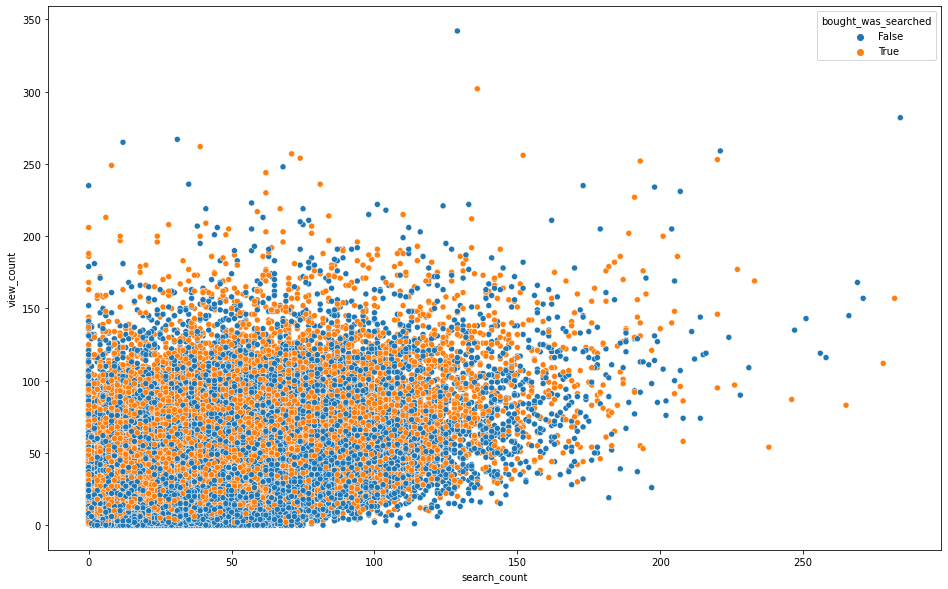

In [9]:
fig, axes = plt.subplots(1, figsize=(16,10))
# for ax in axes:
#   ax.set_xlim(0,30)
# sns.countplot(df.view_count, ax=axes[0], order=list(range(30)))
# sns.countplot(df.search_count, ax=axes[1], order=list(range(30)))
sns.scatterplot(x=df.search_count, y=df.view_count, ax=axes, 
                hue=df.bought_was_searched)

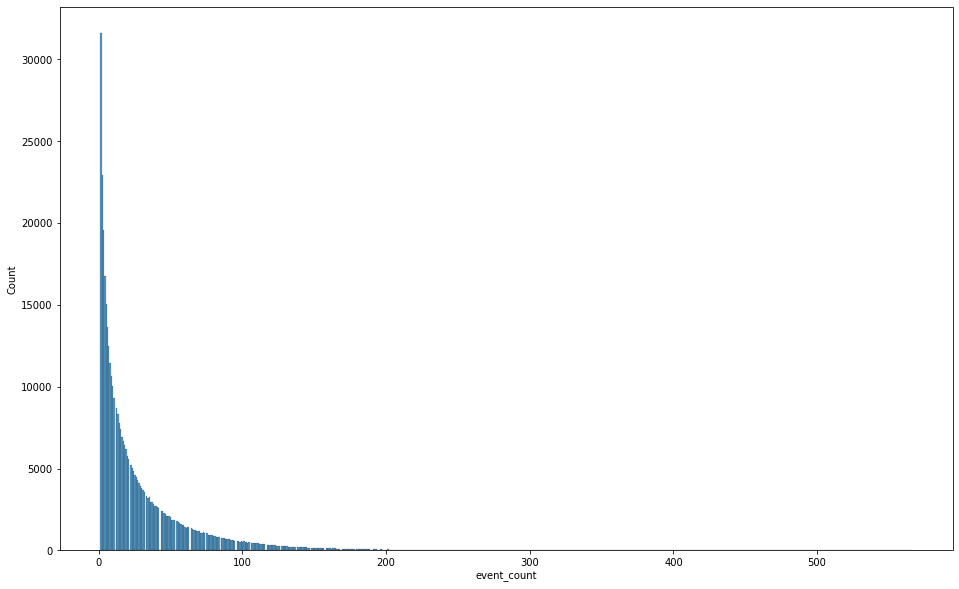

In [10]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.histplot(x=df.event_count, ax=axes)

In [11]:
len(df), len(df[(df.search_count < 150) & (df.view_count < 150)]), len(df[(df.search_count < 150) & (df.view_count < 150)])/len(df)

(413163, 412312, 0.9979402802283844)

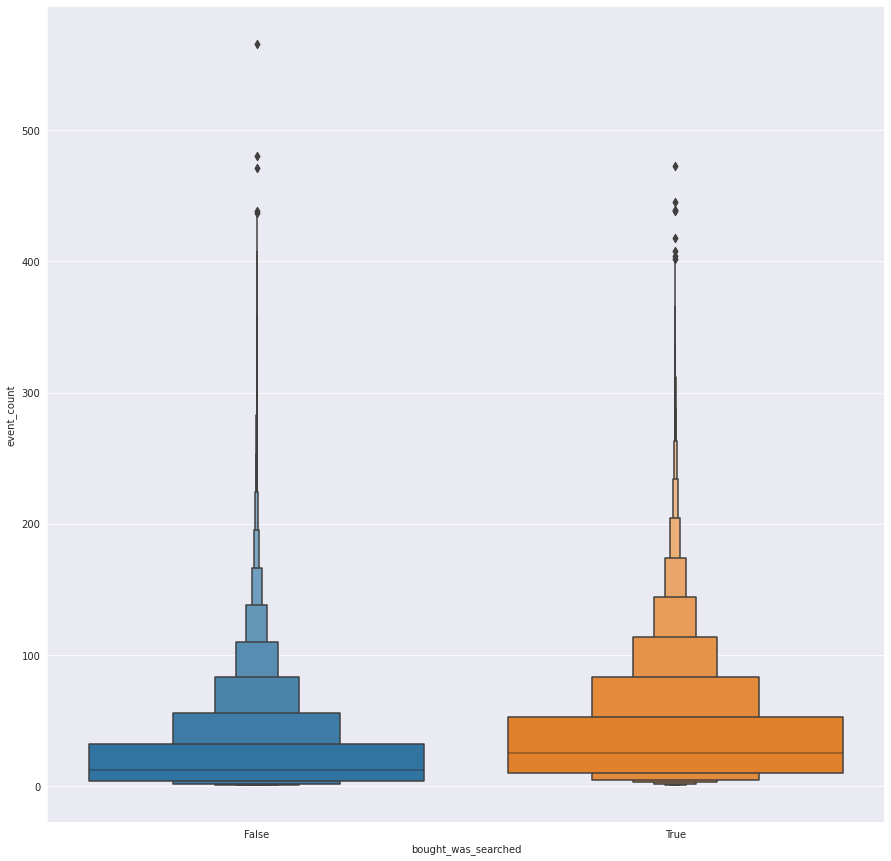

In [12]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,15))

sns.boxenplot(x=df.bought_was_searched, y =df.event_count , ax=ax)


In [13]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

itemdf = pd.DataFrame(item_data)
del item_data
del gz

In [14]:
itemdf.head()

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,None,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,None,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,None,1599.00,MLM1652,used


In [15]:
df.item_bought.isin(itemdf.item_id).value_counts()

True    413163
Name: item_bought, dtype: int64

In [16]:
df_joined = pd.merge(df, itemdf, left_on='item_bought', right_on='item_id', how='left')
df_joined.head()

,user_history,item_bought,bought_was_searched,view_count,search_count,event_count,item_id,title,domain_id,product_id,price,category_id,condition
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,False,18,1,19,1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,None,90.00,MLB135384,new
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,True,8,5,13,228737,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,9015547,169.00,MLB264021,new
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,False,2,0,2,1909110,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,None,300.00,MLB5092,new
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370,False,7,6,13,1197370,Leia A Descrição Por Favor - Maquininha Point ...,MLB-CARD_PAYMENT_TERMINALS,None,16.90,MLB277951,new
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207,True,46,23,69,2049207,Smartwatch Xiaomi Amazfit Bip Huami A1608 Orig...,MLB-SMARTWATCHES,9070839,355.99,MLB135384,new


In [17]:
df_joined.groupby('condition').describe()

item_bought                ...    item_id           
                    count          mean  ...        75%        max
condition                                ...                      
new              412637.0  1.057991e+06  ...  1585033.0  2102239.0
not_specified       115.0  1.056598e+06  ...  1333797.0  2049655.0
used                411.0  1.089228e+06  ...  1497812.0  2094313.0

[3 rows x 40 columns]

In [18]:
df_joined.groupby(df_joined.domain_id.str[:4])[['view_count','search_count','event_count']].describe()

view_count                             ... event_count                   
               count       mean        std  min  ...         25%   50%   75%    max
domain_id                                        ...                               
MLB-        354907.0  14.269335  19.263570  0.0  ...         5.0  15.0  38.0  566.0
MLM-         58256.0  14.860787  19.464348  0.0  ...         6.0  16.0  40.0  438.0

[2 rows x 24 columns]

##Conteo de categorías en tabla train_data
Sin diferenciar por pais

In [19]:
df_joined.groupby(df_joined.domain_id.str[4:]).count().sort_values(by='user_history', ascending=False).head(25)

,user_history,item_bought,bought_was_searched,view_count,search_count,event_count,item_id,title,domain_id,product_id,price,category_id,condition
domain_id,,,,,,,,,,,,,
CELLPHONES,27017,27017,27017,27017,27017,27017,27017,27017,27017,23839,27017,27017,27017
SNEAKERS,15016,15016,15016,15016,15016,15016,15016,15016,15016,1327,15016,15016,15016
HEADPHONES,13656,13656,13656,13656,13656,13656,13656,13656,13656,6924,13656,13656,13656
SUPPLEMENTS,10000,10000,10000,10000,10000,10000,10000,10000,10000,3875,10000,10000,10000
SMARTWATCHES,9606,9606,9606,9606,9606,9606,9606,9606,9606,4527,9606,9606,9606
VIDEO_GAMES,5289,5289,5289,5289,5289,5289,5289,5289,5289,1927,5289,5289,5289
DOLLS,4956,4956,4956,4956,4956,4956,4956,4956,4956,241,4956,4956,4956
BOOTS_AND_BOOTIES,4469,4469,4469,4469,4469,4469,4469,4469,4469,0,4469,4469,4469
STREAMING_MEDIA_DEVICES,4415,4415,4415,4415,4415,4415,4415,4415,4415,1988,4415,4415,4415


##Conteo de categorías en tabla item_data
Sin diferenciar por pais

In [20]:
itemdf.groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False).head(25)

,item_id,title,domain_id,product_id,price,category_id,condition
domain_id,,,,,,,
CARS_AND_VANS,55585,55585,55585,44775,55585,55585,55585
CELLPHONES,46425,46425,46425,40234,46425,46425,46425
SNEAKERS,42460,42460,42460,1045,42460,42460,42460
VEHICLE_ACCESSORIES,34011,34011,34011,32,34011,34011,34011
T_SHIRTS,28130,28130,28130,6,28130,28130,28130
DRESSES,24981,24981,24981,12,24981,24981,24981
SUPPLEMENTS,24111,24111,24111,8017,24111,24111,24111
VEHICLE_PARTS,21739,21739,21739,4,21739,21739,21739
CELLPHONE_COVERS,18652,18652,18652,32,18652,18652,18652


In [21]:
type(df_joined['price'][0])

str

In [22]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_joined['price_float'] = df_joined['price'].astype(float)
df_joined.price_float.describe()

count      413163.000
mean         2886.124
std        492725.714
min             0.010
25%            62.000
50%           139.900
75%           261.000
max     100000000.000
Name: price_float, dtype: float64

In [23]:

for col in itemdf.columns:
  print(col, len(itemdf[itemdf[col].isnull()]))

item_id 0
title 0
domain_id 851
product_id 1805749
price 339
category_id 0
condition 856


In [24]:
itemdf[itemdf.product_id.isnull()]

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,None,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,None,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,None,1599.00,MLM1652,used
5,534737,Transmisor Fm Sin Hilos Bluetooth Reproductor ...,MLM-VEHICLE_ACCESSORIES,None,470.00,MLM92472,new
...,...,...,...,...,...,...,...
2102272,1099649,Carrinho De Bebê Stoke,MLB-BABY_STROLLERS,None,1600.00,MLB1386,used
2102273,1482187,Grelha Para Hambúrguer Preta Com Cabo Em Madei...,MLB-KITCHEN_SUPPLIES,None,69.90,MLB193425,new
2102274,1118904,Meia Tam 7/8 Anti Embolia Trombose Antitrombo,MLB-SOCKS,None,118.00,MLB108791,new
2102275,237229,Pano De Boca Cremer Menina Luxo Bordado C/3 Und,MLB-DISPOSABLE_BABY_DIAPERS,None,26.90,MLB40629,new


In [25]:
itemdf.domain_id.isnull().values.any()

True

##CANTIDAD DE PUNTOS DONDE SE VIO ITEMS EN MÁS DE UN PAIS: 44 / 413000

In [26]:
item_list = itemdf['item_id'].tolist()
domain_list = itemdf['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

In [27]:
def count_countries(history):
  countries = []
  for hist in history:
    if hist['event_type'] == 'view':
      # country = itemdf[itemdf.item_id == hist['event_info']].domain_id.str[:3].values[0]
      # # print(type(country))
      country = item_domain_dict[hist['event_info']]
      if country:
        countries.append(country[:3])
  return len(set(countries))

df_joined['multiple_countries'] = df_joined.user_history.apply(count_countries) 
# df_joined['multiple_countries'] = df_joined.user_history.apply(lambda events: (len(set([itemdf[itemdf.item_id == int(float(history['event_info']))].domain_id.str[:3] for history in events if history['event_type'] == 'view'])) != 1)) 
df_joined.multiple_countries.value_counts()

1    386291
0     26828
2        44
Name: multiple_countries, dtype: int64

##El domain de la compra estuvo entre los items vistos? 
Cierto para aprox el 50% de los casos (203857 sobre 413163)

In [28]:
df_joined['domain_was_searched'] = df_joined.apply(lambda row: row['domain_id'] in [item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'], axis=1)
df_joined.domain_was_searched.value_counts()

False    209306
True     203857
Name: domain_was_searched, dtype: int64

##Cuántas veces aparece el domain de la compra?

In [30]:
def contar_domain(row):
  count = 0
  if row.domain_was_searched == False:
    return 0
  else:
    for history in row['user_history']:
      if history['event_type'] == 'view':
        if item_domain_dict[history['event_info']] == row.domain_id:
          count += 1
    return count

df_joined['domain_views_times'] = df_joined.apply(contar_domain, axis=1)


0         18
1          7
2          0
3          0
4          5
          ..
413158    34
413159     0
413160     0
413161     0
413162     0
Name: domain_views_times, Length: 413163, dtype: int64

(0.0, 20.0)

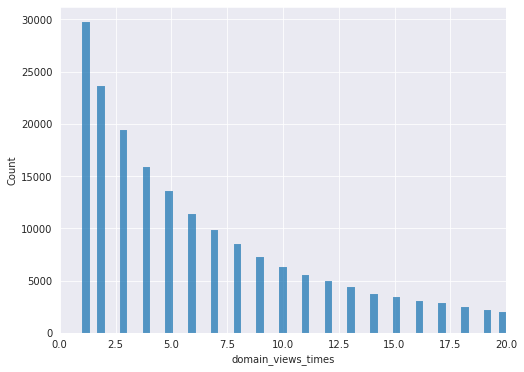

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'], ax=ax)
ax.set_xlim(0,20)

##Relación vistas del domain de la compra / vistas totales:

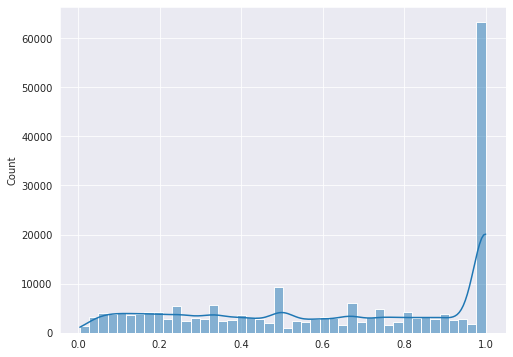

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'] / df_joined[df_joined.domain_was_searched == True]['view_count'], 
             ax=ax, kde=True)
# ax.set_xlim(0,20)

##Sirve categorizar a los compradores según horas en las que hacen searches y views?

##Sirve categorizar a los compradores según la cantidad de views o searches que hacen?

In [29]:
# print(df.columns)
# for col in df.columns:
#   print(col,'-------asd', print(df[col].duplicated().value_counts()))
#   print('\n \n \n')

# Nueva sección